# Notes on Chapter 0 of Statistical Rethinking 2nd Edition by Richard McElreath

These notes will probably focus on the code examples, including possible translations into python/tensorflow probability.  I am neither an expert in Baysean theory nor in TensorFlow, so there may be much cleaner ways to write the code than what I have here.  Note also that if you want to use python but not need GPU acceleration, you may be better off using a more popular statistical library like SciPy or PyMC3 rather than TensorFlow probability.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from math import pi
import time

import jax
from jax import numpy as jnp
from jax import scipy as jsp
from jax import random as jrandom
from jax.scipy import optimize as jspopt
from matplotlib import pyplot as plt
from rpy2.robjects.packages import importr, data
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import math as tfm
from tensorflow_probability import distributions as tfd
from tensorflow_probability.substrates import jax as jtfp
from tensorflow_probability.substrates.jax import distributions as jtfd

First, we need to install RPy to mix R and python code in the same notebook.

In [3]:
# %pip install --user rpy2 numba pandas

Next, we'll load RPy as an ipython extension to enable the "%%R" magic for entering raw R code

In [4]:
%load_ext rpy2.ipython

Next, lets test it:

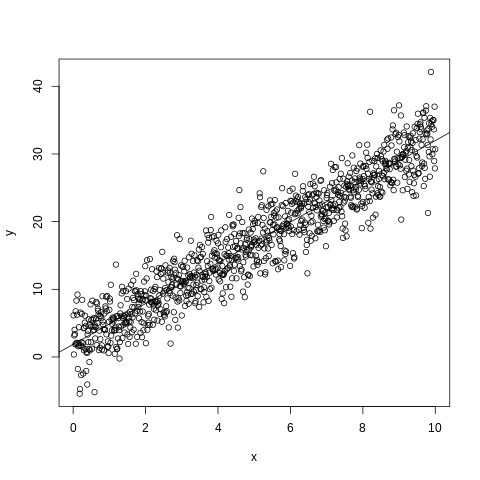

In [5]:
%%R
set.seed(42)
x = 1:1000/100
y = 3 * x + 2 + 3*rnorm(length(x))
m = lm(y ~ x, data.frame(x=x, y=y))
plot(x,y)
abline(m)

The remainder of the notebook will mostly consist of numbered R code blocks from the book and their corresponding python equivalents

### 0.1

In [6]:
%%R
print("All models are wrong, but some are useful.")

[1] "All models are wrong, but some are useful."


In [7]:
print('All models are wrong, but some are useful.')

All models are wrong, but some are useful.


### 0.2

In [8]:
%%R
x <- 1:2
x <- x*10
x <- log(x)
x <- sum(x)
x <- exp(x)
x

[1] 200


In [9]:
x = tf.range(1,3, dtype=tf.float64)
x = x*10
x = tfm.log(x)
x = tfm.reduce_sum(x)
x = tf.exp(x)
x

<tf.Tensor: shape=(), dtype=float64, numpy=200.0000000000001>

In [10]:
x = jnp.arange(1,3)
x = x*10
x = jnp.log(x)
x = x.sum()
x = jnp.exp(x)
x

Array(200.00002, dtype=float32)

### 0.3

In [11]:
%%R
print(log(0.01^200))
print(200 * log(0.01))

[1] -Inf
[1] -921.034


In [12]:
print(tfm.log(0.01**200))
print(200*tfm.log(0.01))

tf.Tensor(-inf, shape=(), dtype=float32)
tf.Tensor(-921.03406, shape=(), dtype=float32)


In [13]:
print(jnp.log(0.01**200))
print(200*jnp.log(0.01))

-inf
-921.03406


### 0.4

(Intercept)       speed 
 -17.579095    3.932409 


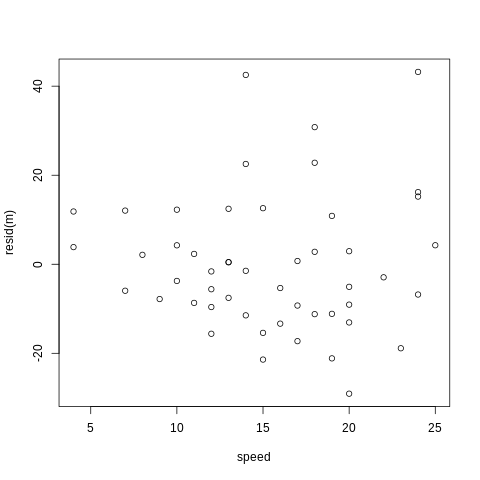

In [14]:
%%R

data(cars)
m <- lm(dist ~ speed, cars)
print(coef(m))
plot(resid(m) ~ speed, data=cars)

Loading the data is a little more painful because we have to load it from R using RPy

In [15]:
# load the cars dataset from R
datasets = importr('datasets')
cars = data(datasets).fetch('cars')['cars']
speed = tf.constant(cars[0])
distance = tf.constant(cars[1])

There does not seem to be an obvious linear model fitting function in tensorflow. One possiblity equivalent would be to calculate it using the pseudoinverse:

tf.Tensor([-17.57909489   3.93240876], shape=(2,), dtype=float64)


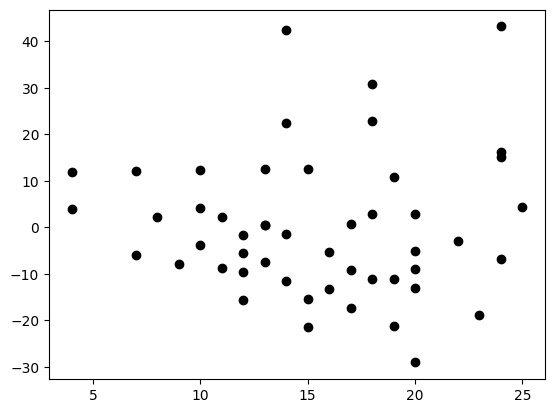

In [16]:
X_aug = tf.stack([tf.ones_like(speed), speed], axis=-1) # add a ones column to speed for the constant offset
beta = tf.tensordot(tf.linalg.pinv(X_aug), distance, axes=1)
print(beta)
plt.plot(speed, distance - tf.tensordot(X_aug, beta, axes=1), 'ok')

Alternatively, maybe the least-squares function is more obvious?:

tf.Tensor([-17.57909489   3.93240876], shape=(2,), dtype=float64)


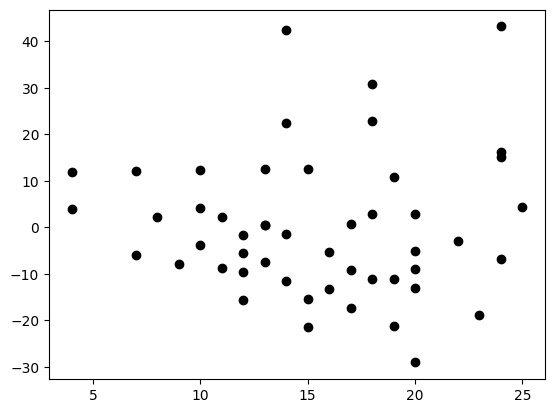

In [17]:
X_aug = tf.stack([tf.ones_like(speed), speed], axis=-1) # add a ones column to speed for the constant offset
beta = tf.linalg.lstsq(X_aug, tf.expand_dims(distance,-1), fast=False)[:,0]
print(beta)
plt.plot(speed, distance - tf.tensordot(X_aug, beta, axes=1), 'ok')

We'll use least-squares again for JAX.

[-17.579134    3.9324112]


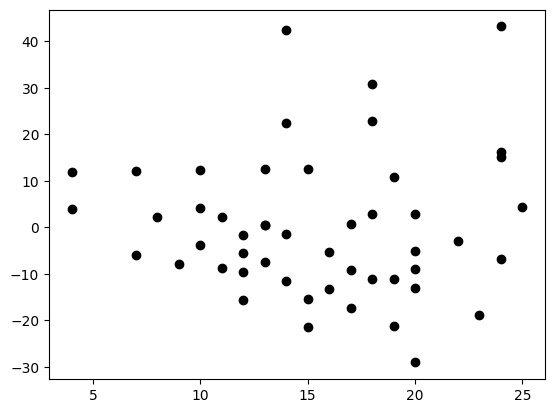

In [18]:
speed = jnp.array(cars[0])
distance = jnp.array(cars[1])
X_aug = jnp.stack([jnp.ones_like(speed), speed], axis=-1) # add a ones column to speed for the constant offset
beta = jnp.linalg.lstsq(X_aug, distance)[0]
print(beta)
plt.plot(speed, distance - X_aug @ beta, 'ok')

### 0.5

In [19]:
%%R

# install.packages(c("coda", "mvtnorm", "devtools", "dagitty"))
# library(devtools)
# devtools::install_github("rmcelreath/rethinking")

NULL


In [20]:
# This library is not available for python, so the R code above (or its Rpy equivalent) is sufficient